In [44]:
import sumolib
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np




First let's read in the graph file and see if it works properly

## Data handling

In [45]:
#Function to read in the network we work with into a networkx object with the nodes and edges, no features yet
def read_sumo_net(filename):
    net = sumolib.net.readNet(filename)
    G = nx.Graph()
    
    # Add nodes
    for node in net.getNodes():
        G.add_node(node.getID(), pos=(node.getCoord()))
    # Add edges
    for edge in net.getEdges():
        for lane in edge.getLanes():
            edge_id = lane.getEdge().getID()
            starting_node_id = net.getEdge(edge_id).getFromNode().getID()
            ending_node_id = net.getEdge(edge_id).getToNode().getID()
            G.add_edge(starting_node_id, ending_node_id, edge_id = edge_id)
    return G

#Function to add the features to the network graph we created already

def add_edge_features_from_xml(G, xml_filename, interval_begin):
    # Parse the XML file
    tree = ET.parse(xml_filename)
    root = tree.getroot()
    #Find the interval corresponding to the interval_begin time 
    interval = root.find(f'.//interval[@begin="{interval_begin}"]')
    #Extract all the features of the edges
    edges = interval.findall('.//edge')
    for edge in edges:
        edge_id = edge.get('id')
        edge_features = {}
        edge_features['left'] = edge.get('left')
        #We can add other features here
        #Iterate through the edges in the existing NetworkX graph
        for xml_edge_id, xml_edge_data in G.edges.items():
            if G.get_edge_data(xml_edge_id[0],xml_edge_id[1])['edge_id'] == edge_id:
                G.edges[xml_edge_id].update(edge_features)
    return G

def nx_to_pyg(graph):
    # Convert NetworkX graph to PyTorch Geometric Data object
    pyg_data = Data.Data()
    #We have to number the nodes, because that is how Data object works
    # Mapping between string node IDs and numerical indices
    node_id_to_index = {node_id: i for i, node_id in enumerate(graph.nodes)}

    # Set node features
    num_nodes = graph.number_of_nodes()
    node_features = np.zeros((num_nodes, 2))  # Assuming num_features is known, this is important to change, if we want to change something, altough I do not think that will be the case for us
    for i, (node, features) in enumerate(graph.nodes(data=True)):
        node_features[i] = [features['pos'][0], features['pos'][1]]  # Add node features accordingly, this case the coordinates
    pyg_data.x = torch.tensor(node_features, dtype=torch.float)

    # Set edge features and edge indices
    edge_index = []
    edge_features = []
    for u, v, features in graph.edges(data=True):
        # Map string node IDs to numerical indices
        u_index = node_id_to_index[u]
        v_index = node_id_to_index[v]
        edge_index.append([u_index, v_index])
        edge_features.append([float(features['left'])])  # Add edge features accordingly, if we add more features, we have to change this line

    pyg_data.edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    pyg_data.edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return pyg_data


#Function to plot the graph
def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10)
    plt.show()
Graph = read_sumo_net('s_gyor.net.xml')

<class 'torch_geometric.data.data.Data'>


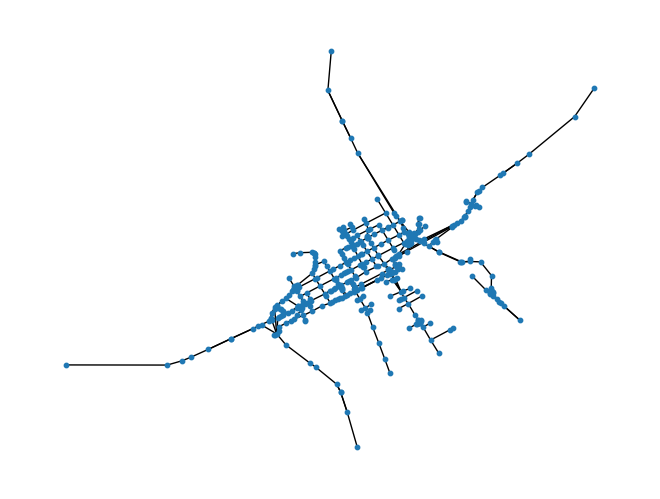

In [46]:
G1 = read_sumo_net('s_gyor.net.xml')
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"11700.00")
pyg_data = nx_to_pyg(G2)
print(type(pyg_data))
plot_graph(G1)

## Neural network

In [55]:
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"10800.00")
data_training = nx_to_pyg(G2)


class GNN(nn.Module):
    def __init__(self, edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(edge_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.conv5 = GCNConv(hidden_dim4, hidden_dim5)
        self.conv6 = GCNConv(hidden_dim5, hidden_dim6)
        self.conv7 = GCNConv(hidden_dim6, hidden_dim7)
        self.conv8 = GCNConv(hidden_dim7, hidden_dim8)
        self.linear = nn.Linear(hidden_dim8, edge_dim)

    def forward(self, edge_features, edge_index):
        x = self.conv1(edge_features, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = self.conv8(x, edge_index)
        x = F.relu(x)
        x = self.linear(x)
        return x

# Assume edge features are stored in data_training.edge_attr
edge_features = data_training.edge_attr

# Normalize the edge features
max_value = edge_features.max()
normalized_edge_features = edge_features / max_value
data_training.edge_attr = normalized_edge_features
data_testing = data_training.clone()

# Get the total number of edges in the dataset
total_num_edges = data_training.num_edges

# Calculate the number of edges to hide 
num_edges_to_hide = int(total_num_edges * 0.7)
num_remaining_edges = total_num_edges - num_edges_to_hide

# Randomly select edges to hide 
edges_to_hide = random.sample(range(total_num_edges), num_edges_to_hide)
remaining_edges = list(set(range(total_num_edges)) - set(edges_to_hide))

# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 128
hidden_dim3 = 32
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10000
losses = np.zeros(num_epochs)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = model(data_training.edge_attr, data_training.edge_index)
    
    # Compute loss using the predicted features and the input features of the hidden edges
    loss = criterion(output[edges_to_hide], data_testing.edge_attr[edges_to_hide])
    losses[epoch] = loss
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.10200150310993195
Epoch 11, Loss: 0.06257246434688568
Epoch 21, Loss: 0.0588415265083313
Epoch 31, Loss: 0.058082472532987595
Epoch 41, Loss: 0.05763036012649536
Epoch 51, Loss: 0.05738184228539467
Epoch 61, Loss: 0.05710320174694061
Epoch 71, Loss: 0.05696294084191322
Epoch 81, Loss: 0.05679873004555702
Epoch 91, Loss: 0.05641438812017441
Epoch 101, Loss: 0.05589383468031883
Epoch 111, Loss: 0.05543579161167145
Epoch 121, Loss: 0.05547218397259712
Epoch 131, Loss: 0.055072709918022156
Epoch 141, Loss: 0.05439021438360214
Epoch 151, Loss: 0.053891371935606
Epoch 161, Loss: 0.053066838532686234
Epoch 171, Loss: 0.053734444081783295
Epoch 181, Loss: 0.05247344821691513
Epoch 191, Loss: 0.051191139966249466
Epoch 201, Loss: 0.051173318177461624
Epoch 211, Loss: 0.051509272307157516
Epoch 221, Loss: 0.050434041768312454
Epoch 231, Loss: 0.04956265538930893
Epoch 241, Loss: 0.04916416108608246
Epoch 251, Loss: 0.04954620823264122
Epoch 261, Loss: 0.04881272092461586
Epoch 2

## Data visualization

In [56]:
def losses_epoch_plot(losses, save, save_name):
    fig = plt.figure()
    epochs = np.linspace(start=0, stop=np.size(losses), num=np.size(losses))
    plt.scatter(epochs,losses,c='red')
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(True,which='major',color='gray')
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction= 'in')
    fig.set_size_inches(14,7.5)
    if save:
        plt.savefig(save_name)



def enhanced_histogram(data, bins=30, save=False, save_name='histogram.png'):
    fig = plt.figure()
    plt.hist(data, bins=bins, color='blue', edgecolor='black')
    plt.ylabel('Frequency', fontsize=20)
    plt.xlabel('Difference', fontsize=20)  # Changed to 'Difference' to reflect the data
    plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', color='lightgray', linestyle=':', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    fig.set_size_inches(14, 7.5)
    plt.title('Histogram of Differences', fontsize=22)  # Changed title to reflect the data

    if save:
        plt.savefig(save_name)
    plt.show()

352


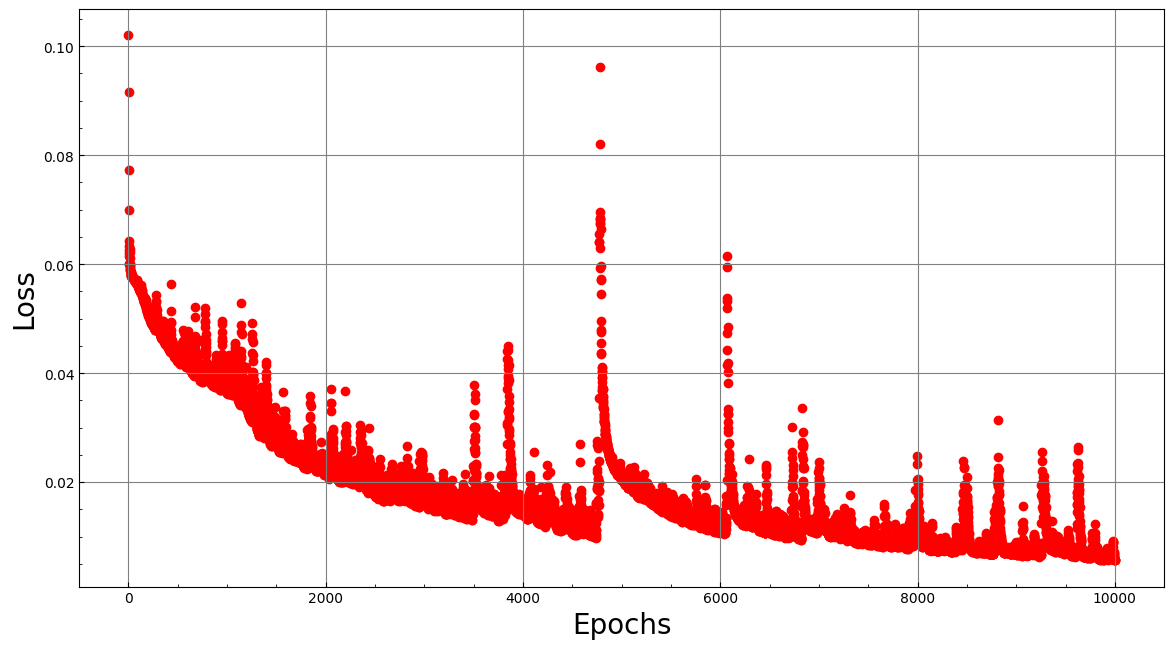

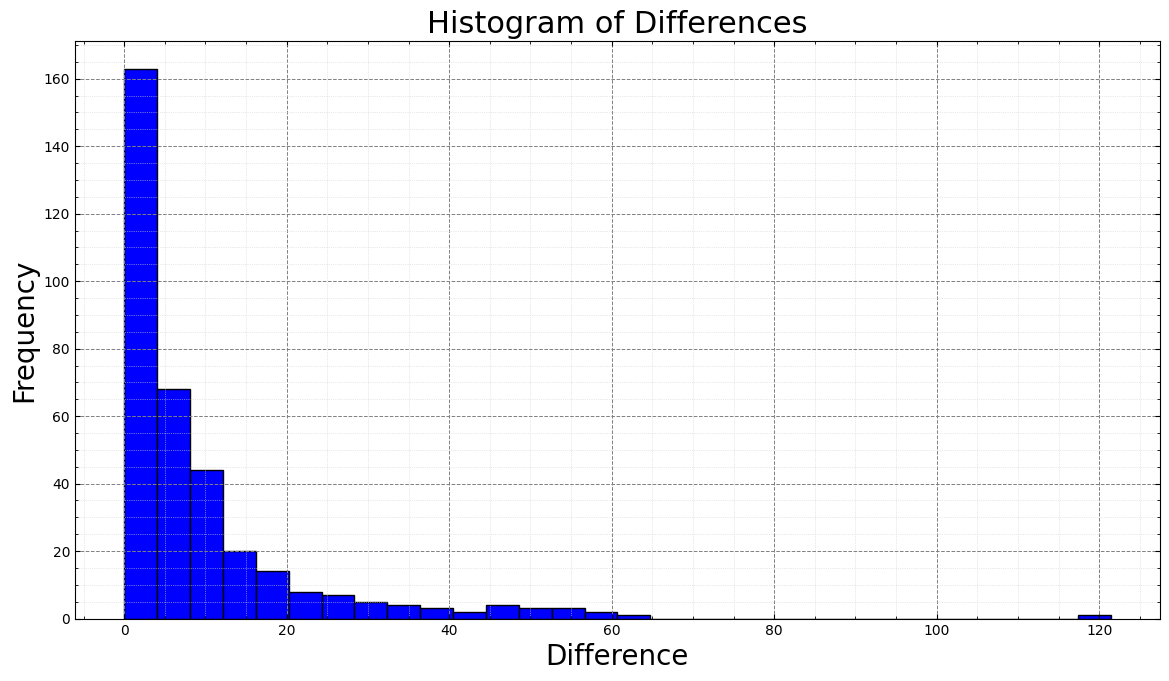

In [57]:
losses_epoch_plot(losses,False,'asd')

N = num_edges_to_hide
print(N)
difference = np.zeros(N)
for i in range(N):
    if output[edges_to_hide][i]<0:
        output[edges_to_hide][i] = 0
    difference[i] = max_value * float(abs(output[edges_to_hide][i] - data_testing.edge_attr[edges_to_hide][i]))
    #print(output[edges_to_hide][i])
enhanced_histogram(difference, bins=30, save=False, save_name='enhanced_histogram.png')
